# 0. Imports

### 0.1 Libs

In [93]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display        import Image
from scipy                  import stats as ss

### 0.2 Helper Functions

In [94]:
def cramer_v(x,y):

    #Função para definir a correlação entre variáveis categóricas.

    # É feita utilizando o metodo "Cramér's V", onde:
        #v = np.sqrt ( (chi2/n) / (min(k-1, r-1)) )
            # Chi2 deriva do teste estatístico de Pearson 
            # n é o número de amostras
            #'K-1' é o número de colunas menos 1 e 'r-1' é o número de linhas -1

    # Diferente da correlação de Pearson para variáveis numéricas, que vai de '-1 a 1', o Cramér's V vai de '0 a 1' 


    cm = pd.crosstab( x, y).values               # Confusion Matrix (cm) - tabela de contingência
    n = cm.sum()                                 # n é o número de amortras
    r, k = cm.shape                              #'K' é o número de colunas e 'r' é o número de linhas
    chi2 = ss.chi2_contingency(cm)[0]
        # Linha 0: resultado do teste de chi2
        # Linha 1: resultado do p-valor
        # Linha 2: número de graus de liberdade
        # Linha 3: tabela de frequência

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )

### 0.3 Loading data

* Fonte: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction

In [60]:
# Credentials to access SQL Database:

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

# Connection with database:

conn = pg.connect(user = username,
                password = pwd,
                host = host,
                port = port,
                database = database)

# Query

query = """
    SELECT
        i.id,
        i.previously_insured,
        i.annual_premium,
        i.vintage,
        i.response,
        u.gender,
        u.age,
        u.region_code,
        u.policy_sales_channel,
        v.driving_license,
        v.vehicle_age,
        v.vehicle_damage
    FROM 
        pa004.users u
        JOIN pa004.vehicle v ON (u.id = v.id)
        JOIN pa004.insurance i ON (u.id = i.id)
"""

df_train_raw = pd.read_sql(query, conn)
conn.close()


/home/vitor/.pyenv/versions/3.9.0/envs/CrossSell/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# 1. Data Description

### 1.0 Overview

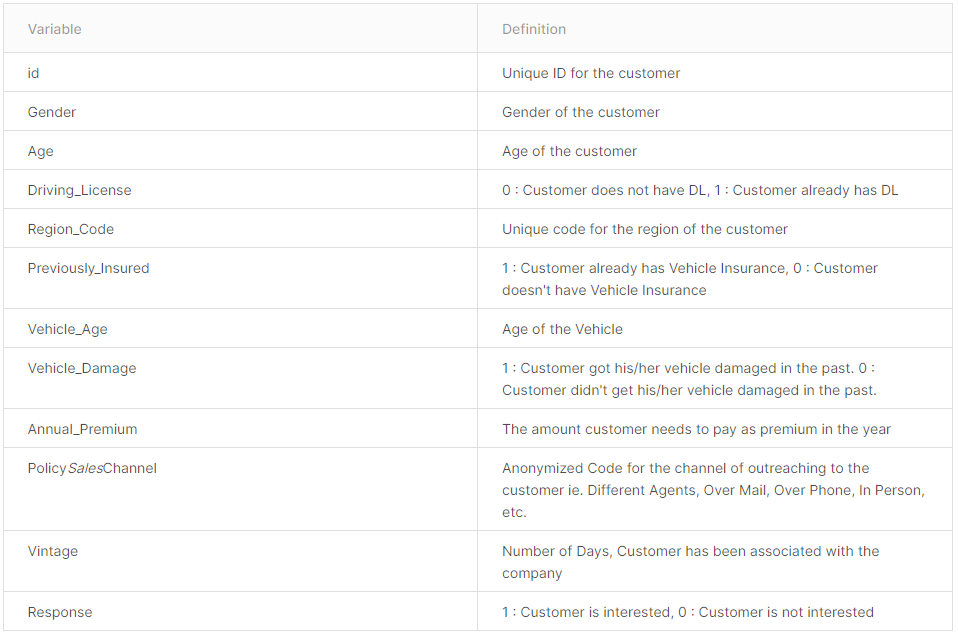

In [61]:
# Variable Definition

Image('../image/data_description.png')

In [62]:
df1 = df_train_raw.copy()

df1

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381070,1,38254.0,127,0,Male,24,8.0,152.0,1,< 1 Year,No
381105,381079,0,39740.0,170,0,Female,58,28.0,26.0,1,1-2 Year,Yes
381106,381082,1,51619.0,80,0,Female,75,28.0,26.0,1,1-2 Year,No
381107,381097,0,34541.0,44,0,Female,49,10.0,26.0,1,1-2 Year,Yes


### 1.1 Data Dimensions

In [63]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:381109
Number of Columns:12


### 1.2 Data Types

In [64]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

### 1.3 Check NA

In [65]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

### 1.4 Change Types

In [66]:
df1['previously_insured'] = df1['previously_insured'].apply(lambda x: 'yes' if x==1 else 'no')
df1['driving_license'] = df1['driving_license'].apply(lambda x: 'yes' if x==1 else 'no')
df1['response'] = df1['response'].apply(lambda x: 'yes' if x==1 else 'no')

df1.dtypes

id                        int64
previously_insured       object
annual_premium          float64
vintage                   int64
response                 object
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license          object
vehicle_age              object
vehicle_damage           object
dtype: object

### 1.5 Descriptive Statistics

##### 1.5.0 Defining Datasets

In [67]:
num_attributes = df1[['annual_premium', 'vintage', 'age']]
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

##### 1.5.1 Numerical Atributes

In [68]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
1,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688
2,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655


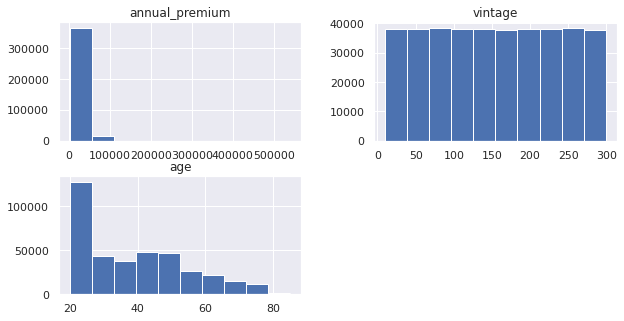

In [69]:
num_attributes.hist();

##### 1.5.1 Categorical Atributes

<AxesSubplot:xlabel='response', ylabel='id'>

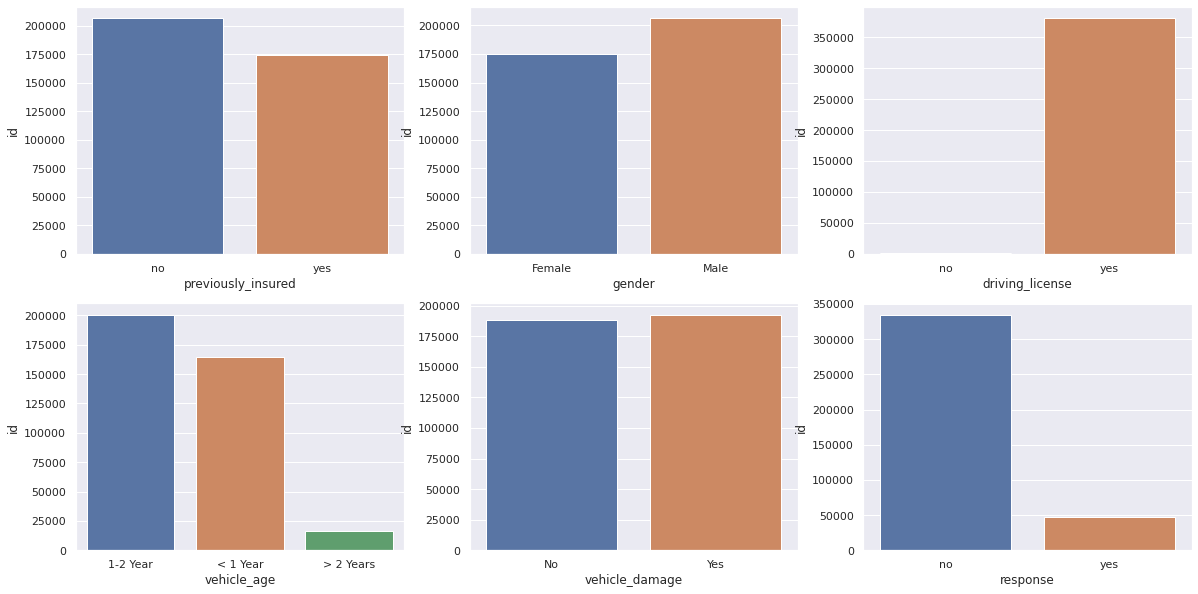

In [70]:
sns.set(rc={'figure.figsize':(20,10)})

plt.subplot(2,3,1)
aux1 = df1[['id', 'previously_insured']].groupby(['previously_insured']).count().reset_index()
sns.barplot(x='previously_insured', y='id', data=aux1)

plt.subplot(2,3,2)
aux1 = df1[['id', 'gender']].groupby(['gender']).count().reset_index()
sns.barplot(x='gender', y='id', data=aux1)

plt.subplot(2,3,3)
aux1 = df1[['id', 'driving_license']].groupby(['driving_license']).count().reset_index()
sns.barplot(x='driving_license', y='id', data=aux1)

plt.subplot(2,3,4)
aux1 = df1[['id', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(x='vehicle_age', y='id', data=aux1)

plt.subplot(2,3,5)
aux1 = df1[['id', 'vehicle_damage']].groupby(['vehicle_damage']).count().reset_index()
sns.barplot(x='vehicle_damage', y='id', data=aux1)

plt.subplot(2,3,6)
aux1 = df1[['id', 'response']].groupby(['response']).count().reset_index()
sns.barplot(x='response', y='id', data=aux1)

# 2. Feature Engineering

### 2.1 Mind Map

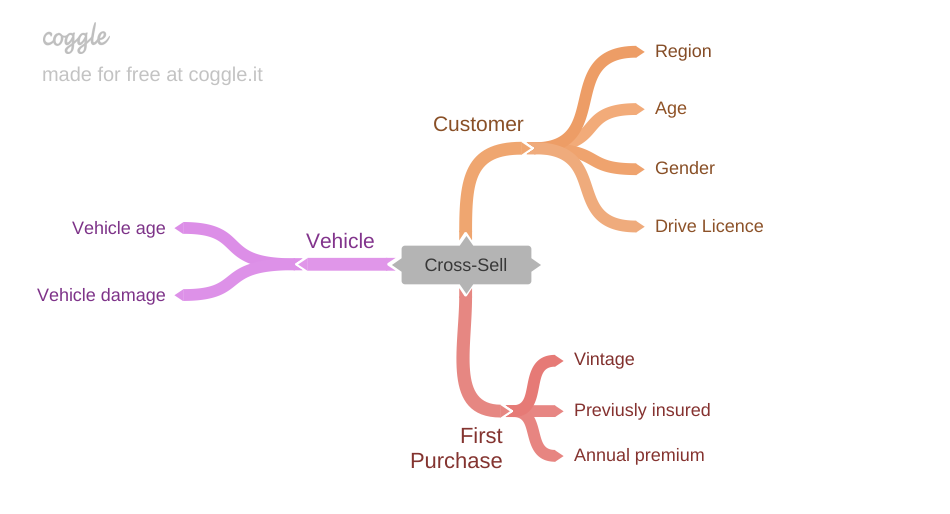

In [71]:
Image('../image/mind_map.png')

### 2.2 Hypothesis Definition

##### 2.2.1 Customer

- H1: Younger drivers are more likely to buy vehicle insurance
- H2: Women are more likely to buy vehicle insurance
- H3: Younger women are more likely to buy
- H4: Customers with driving licence are more likely to buy vehicle insurance

##### 2.2.2 First Purchase

- H5: Customers with more associate time are more likely to buy a vehicle insurance
- H6: Customers that already have vehicle insurance are more likely to buy.
- H7: Customers with the biggest annual premium are more likely to buy

##### 2.2.3 Vehicle

- H8: Customers with newer car are more likely to buy
- H9: Customers that already have vehicle damage are more likely to buy

### 2.3 Feature Engineering

In [72]:
df2 = df1.copy()

In [73]:
df2.sample(5).T

,33830,291754,152329,198796,344625
id,270228,44411,74438,63006,87979
previously_insured,yes,yes,no,yes,yes
annual_premium,40962.0,30518.0,2630.0,2630.0,31361.0
vintage,244,101,132,298,282
response,no,no,no,no,no
gender,Male,Female,Male,Male,Female
age,62,29,52,23,28
region_code,11.0,27.0,8.0,20.0,24.0
policy_sales_channel,120.0,152.0,26.0,152.0,152.0
driving_license,yes,yes,yes,yes,yes


In [74]:
# Vintage Month
df2['vintage_month'] = df2['vintage'] / 30
df2['vintage_month'] = df2['vintage_month'].astype(int)

In [75]:
# Age group

for i in range(len(df2)):
    if df2.loc[i, 'age'] < 35:
        df2.loc[i, 'age_group'] = 'young'
    elif df2.loc[i, 'age'] <55:
        df2.loc[i, 'age_group'] = 'adults'
    else:
        df2.loc[i, 'age_group'] = 'seniors'


In [76]:
# Vintage quarter group

for i in range(len(df2)):
    if df2.loc[i, 'vintage_month'] < 3:
        df2.loc[i, 'vintage_group'] = 't1'
    elif df2.loc[i, 'vintage_month'] <6:
        df2.loc[i, 'vintage_group'] = 't2'
    elif df2.loc[i, 'vintage_month'] <9:
        df2.loc[i, 'vintage_group'] = 't3'
    else:
        df2.loc[i, 'vintage_group'] = 't4'

In [77]:
# Premium Group

for i in range(len(df2)):
    if df2.loc[i, 'annual_premium'] < 30000:
        df2.loc[i, 'premium_group'] = 'small'
    elif df2.loc[i, 'annual_premium'] <50000:
        df2.loc[i, 'premium_group'] = 'medium'
    elif df2.loc[i, 'annual_premium'] <100000:
        df2.loc[i, 'premium_group'] = 'large'
    else:
        df2.loc[i, 'premium_group'] = 'extra_large'


In [78]:
df2['premium_group'].value_counts()

medium         182835
small          166065
large           31431
extra_large       778
Name: premium_group, dtype: int64

# 3. Filtering Variables

# 4. Exploratory Data Analysis

### 4.1 Univariate Analysis

In [79]:
df4 = df2.copy()

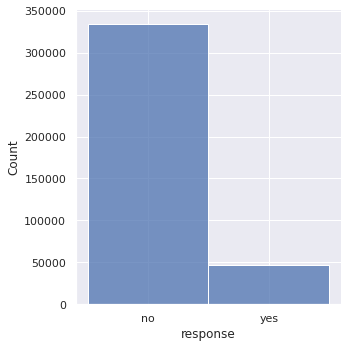

In [80]:
# Response Variable

sns.displot(df4['response'])

### 4.2 Bivariate Analysis

- H1: Younger drivers are more likely to buy vehicle insurance
- H2: Women are more likely to buy vehicle insurance
- H3: Customers with drive licence are more likely to buy vehicle insurance
- H4: Customers with more associate time are more likely to buy a vehicle insurance
- H5: Customers that already have vehicle insurance are more likely to buy.
- H6: Customers with the biggest annual premium are more likely to buy
- H7: Customers with newer car are more likely to buy
- H8: Customers that already have vehicle damage are more likely to buy

##### H1: Younger drivers are more likely to buy vehicle insurance

**False:** 6,1% of the young group are likely to buy, while 20,9% of the adults group and 11,8% of the seniors group are likely to buy.

,age_group,response,id,rate
1,adults,yes,27691,20.895398
3,seniors,yes,7886,11.821139
5,young,yes,11133,6.121203


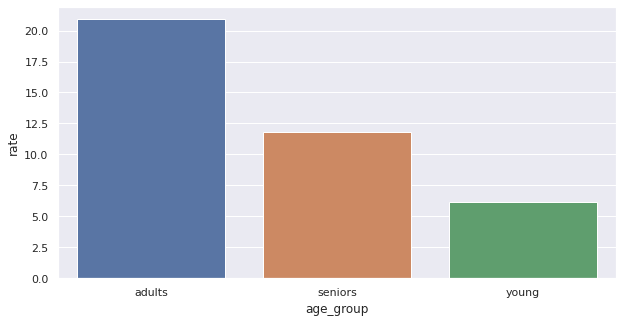

In [81]:
aux1 = df4[['id', 'response', 'age_group']].groupby(['age_group', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['age_group'] == aux1.loc[i, 'age_group'])].sum()) *100

aux1 = aux1[aux1['response'] == 'yes']

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='age_group', y='rate', data=aux1)

aux1

##### H2: Women are more likely to buy vehicle insurance

**False:** 10,4% of the female group are likely to buy, while 13,8% of male group are likely to buy.

,gender,response,id,rate
1,Female,yes,18185,10.390241
3,Male,yes,28525,13.841107


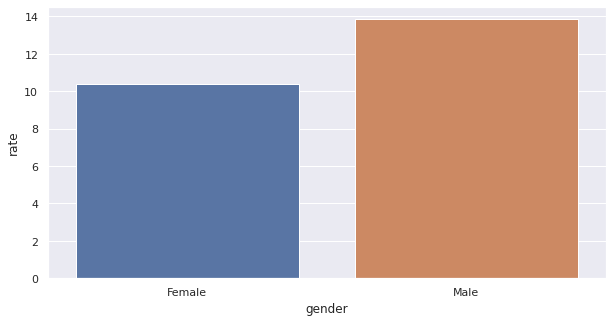

In [82]:
aux1 = df4[['id', 'response', 'gender']].groupby(['gender', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['gender'] == aux1.loc[i, 'gender'])].sum()) *100

aux1 = aux1[aux1['response'] == 'yes']

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='gender', y='rate', data=aux1)

aux1

##### H3: Customers with driving licence are more likely to buy vehicle insurance

**True:** 12,2% of customers that have driving licence are likely to buy, while 5% of customers that don't have are likely to buy.

,driving_license,response,id,rate
1,no,yes,41,5.049261
3,yes,yes,46669,12.271724


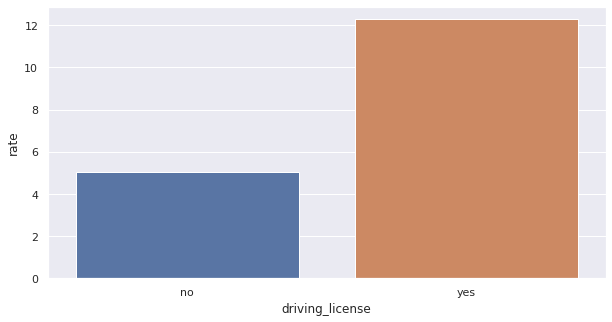

In [83]:
aux1 = df4[['id', 'response', 'driving_license']].groupby(['driving_license', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['driving_license'] == aux1.loc[i, 'driving_license'])].sum()) *100

aux1 = aux1[aux1['response'] == 'yes']

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='driving_license', y='rate', data=aux1)

aux1

##### H4: Customers with more associate time (vintage) are more likely to buy a vehicle insurance

**False:** It doesn't matter the associate time, every vintage group has the same rate to buy a vehicle insurance.

,vintage_group,response,id,rate
1,t1,yes,12975,12.321469
3,t2,yes,14402,12.170841
5,t3,yes,14531,12.28484
7,t4,yes,4802,12.253438


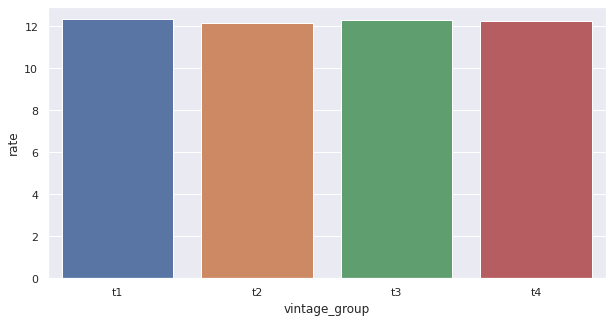

In [84]:
aux1 = df4[['id', 'response', 'vintage_group']].groupby(['vintage_group', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['vintage_group'] == aux1.loc[i, 'vintage_group'])].sum()) *100

aux1 = aux1[aux1['response'] == 'yes']

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='vintage_group', y='rate', data=aux1)

aux1

##### H5: Customers that don't have vehicle insurance are more likely to buy.

**True:** Those who don't are previously insured are more likely to buy a vehicle insurance.

,previously_insured,response,id,rate
1,no,yes,46552,22.545416
3,yes,yes,158,0.090478


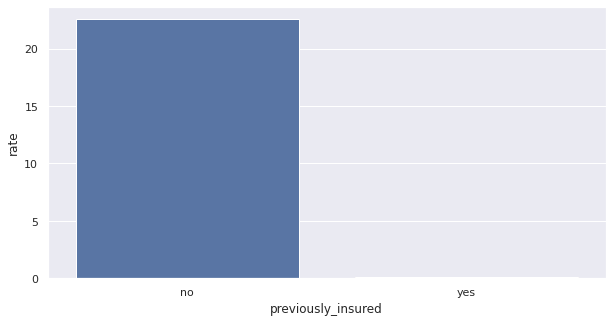

In [85]:
aux1 = df4[['id', 'response', 'previously_insured']].groupby(['previously_insured', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['previously_insured'] == aux1.loc[i, 'previously_insured'])].sum()) *100

aux1 = aux1[aux1['response'] == 'yes']

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='previously_insured', y='rate', data=aux1)

aux1

##### H6: Customers with the biggest annual premium are more likely to buy.

**True:** Those who annual premium are over 50k dolars are more likely to buy a vehicle insurance.

,premium_group,response,id,rate
1,extra_large,yes,123,15.809769
3,large,yes,4776,15.195189
5,medium,yes,23277,12.731151
7,small,yes,18534,11.16069


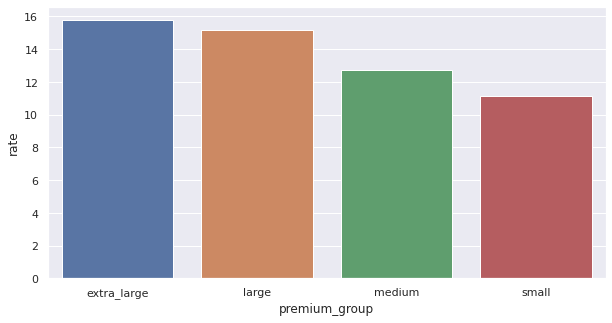

In [86]:
aux1 = df4[['id', 'response', 'premium_group']].groupby(['premium_group', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['premium_group'] == aux1.loc[i, 'premium_group'])].sum()) *100

aux1 = aux1[aux1['response'] == 'yes']

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='premium_group', y='rate', data=aux1)

aux1

##### H7: Customers with newer car are more likely to buy.

**False:** How older the vehicle, the more likely to buy the customer.

,vehicle_age,response,id,rate
1,1-2 Year,yes,34806,17.375547
3,< 1 Year,yes,7202,4.370517
5,> 2 Years,yes,4702,29.374649


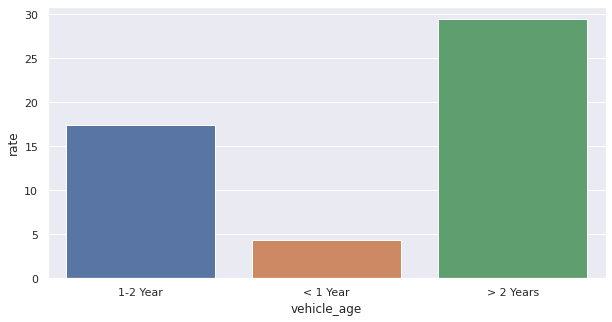

In [87]:
aux1 = df4[['id', 'response', 'vehicle_age']].groupby(['vehicle_age', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['vehicle_age'] == aux1.loc[i, 'vehicle_age'])].sum()) *100

aux1 = aux1[aux1['response'] == 'yes']

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='vehicle_age', y='rate', data=aux1)

aux1

##### H8: Customers that already had vehicle damage are more likely to buy.

**True:** Those who already had vehicle damage are more likely to buy.

,vehicle_damage,response,id,rate
1,No,yes,982,0.520414
3,Yes,yes,45728,23.765546


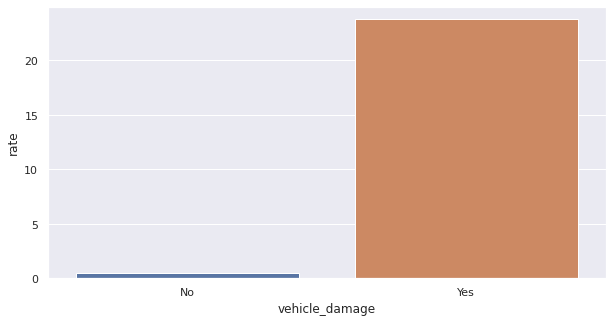

In [88]:
aux1 = df4[['id', 'response', 'vehicle_damage']].groupby(['vehicle_damage', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['vehicle_damage'] == aux1.loc[i, 'vehicle_damage'])].sum()) *100

aux1 = aux1[aux1['response'] == 'yes']

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='vehicle_damage', y='rate', data=aux1)

aux1

### 4.3 Multivariate Analysis

##### 4.3.1 Numerical Attributes

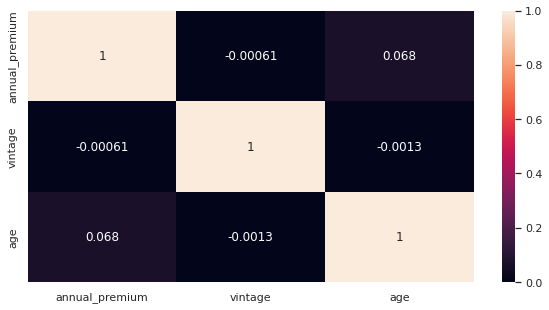

In [89]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation , annot = True);

##### 4.3.1 Categorical Attributes

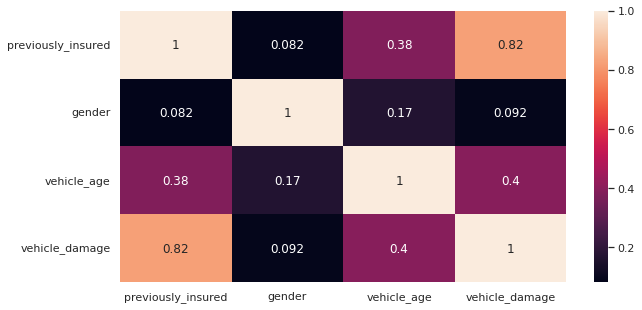

In [96]:
# Only categorical data:
a = df4[['previously_insured', 'gender', 'vehicle_age', 'vehicle_damage']]

# Calculate Cramér's V:
a1 = cramer_v(a['previously_insured'], a['previously_insured'])
a2 = cramer_v(a['previously_insured'], a['gender'])
a3 = cramer_v(a['previously_insured'], a['vehicle_age'])
a4 = cramer_v(a['previously_insured'], a['vehicle_damage'])

a5 = cramer_v(a['gender'], a['previously_insured'])
a6 = cramer_v(a['gender'], a['gender'])
a7 = cramer_v(a['gender'], a['vehicle_age'])
a8 = cramer_v(a['gender'], a['vehicle_damage'])

a9  = cramer_v(a['vehicle_age'], a['previously_insured'])
a10 = cramer_v(a['vehicle_age'], a['gender'])
a11 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a12 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a13 = cramer_v(a['vehicle_damage'], a['previously_insured'])
a14 = cramer_v(a['vehicle_damage'], a['gender'])
a15 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a16 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

d = pd.DataFrame({'previously_insured':   [a1, a2, a3, a4],
                  'gender':               [a5, a6, a7, a8],
                  'vehicle_age':          [a9, a10, a11, a12],
                  'vehicle_damage':       [a13, a14, a15, a16]})

d = d.set_index(d.columns)

sns.heatmap (d, annot = True);